In [1]:
import cv2
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# Using Reinforcement Learning to solve a maze puzzle
The structure of the code is as follows:
- data process
- use RL to train the model
- show the results

If you want to directly test the model without training (which costs about half an hour), you can load the pretrained Q table in the last section

# data process

### load the image

In [2]:
maze_image = cv2.imread('maze.jpg')
maze = cv2.cvtColor(maze_image, cv2.COLOR_BGR2GRAY)

In [3]:
maze.shape

(480, 620)

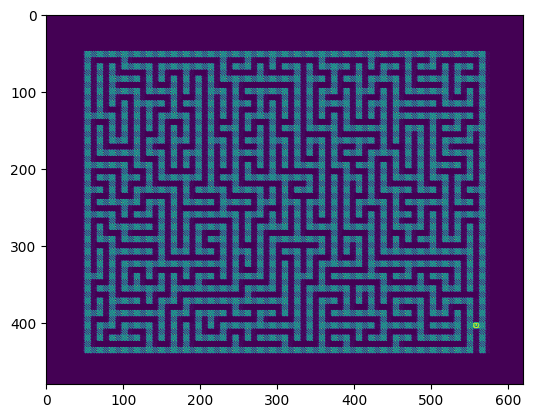

In [4]:
plt.imshow(maze)

### clean the image

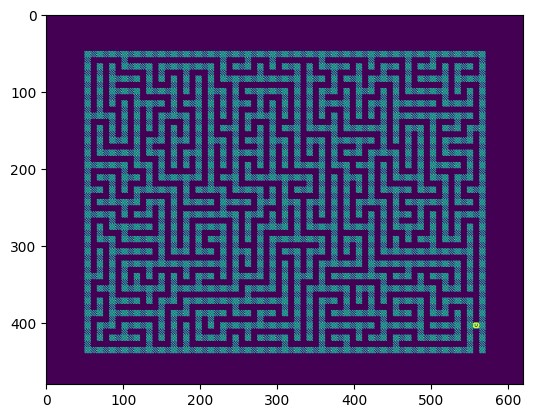

In [5]:
maze3 = maze.copy()
maze3[maze3 < 80] = 0
maze3[maze3 >= 80] = 255
plt.imshow(maze3)

In [6]:
mask = np.where(maze3 != 0)
up1, down1, up2, down2 = np.max(mask[0]), np.min(mask[0]), np.max(mask[1]), np.min(mask[1])

In [7]:
up1, up2, down1, down2

(439, 569, 48, 50)

In [8]:
l1 = (up1 - down1 + 1) // 8
l2 = (up2 - down2 + 1) // 8

In [9]:
l1, l2

(49, 65)

### convert image to a 2d array

In [10]:
maze_shape = np.array([l1, l2])

In [11]:
maze_array = np.zeros(maze_shape)
for i in range(49):
    for j in range(65):
        pixes = maze3[48+i*8: 48+i*8+8, 50+j*8: 50+j*8+8]
        pix_ave = np.mean(pixes)
        maze_array[i, j] = pix_ave

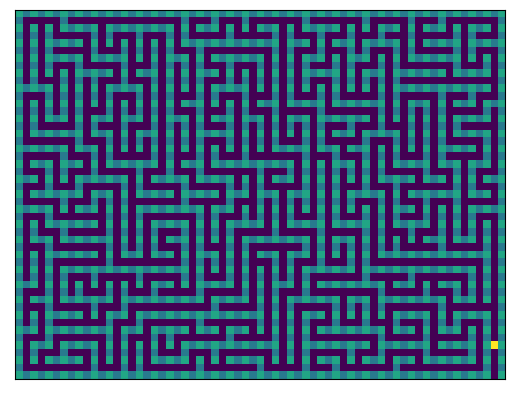

In [12]:
plt.imshow(maze_array)
plt.xticks([])
plt.yticks([])
plt.show()

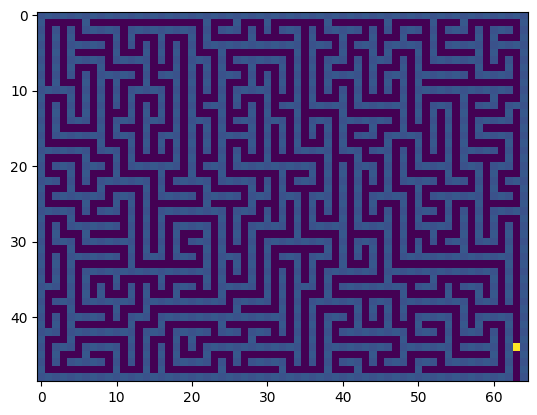

In [13]:
values = pd.value_counts(maze_array.flatten()).keys()
maze_array[maze_array == values[1]] = 1
maze_array[maze_array == values[2]] = 1.1
maze_array[maze_array == values[3]] = 4
plt.imshow(maze_array)
plt.savefig('maze_array.png', dpi=300)

# Q-learning

### utils

In [17]:
def sub2ind(rows, cols):
    # convert (row col) coordinate to a single index
    array_shape = maze_shape
    return rows*array_shape[1] + cols

def ind2sub(ind):
    # convert single index to (row, col) coordinate
    array_shape = maze_shape
    ind = np.asarray(ind)
    assert np.logical_and(0 <= ind, ind < array_shape[0] * array_shape[1]).all(), "{} is out of the maze".format(ind)
    rows = (ind.astype('int') // array_shape[1])
    cols = (ind.astype('int') % array_shape[1])
    return (rows, cols)

def step(location, direction):
    # direction is: 0(left), 1(down), 2(right), 3(up)
    # change the location corresponding to the direction
    diff = np.array([[0, 1, 0, -1],
                     [-1, 0, 1, 0]], dtype=int)
    location += diff[:, direction]
    # assert location.min() >= 0, "{} is out of the maze".format(location)
    return location  

### main class for Q learning

In [18]:
class MazeWalker:
    def __init__(self, tab_Q, start, epsilon=0.1, lr=0.5, gamma=0.9):
        '''
        tab_Q: (width*height, 4), the initial Q table;
        start: (2,), the start point of the maze;
        epsilon: the frequency threshold for the epsilon-greedy algorithm;
        lr: learning rate for Q learning;
        gamma: discount factor for Q learning.
        '''
        self.tab_Q = tab_Q
        self.start = sub2ind(start[0], start[1])
        self.end = sub2ind(1, 1)
        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma
        
    def update_end(self, end=None):
        # if end is not None, set the end point of the maze. Otherwise, randomly
        # select a point *which is not the wall*
        if end is None:
            possible_end = np.where(self.tab_Q.max(axis=1) >= 0)[0]
            end = np.random.choice(possible_end)
        self.end = end
        return end
        
    def one_step(self, current, explore=False):
        # select an action (via epsilon-greedy), 
        # return the action, next location, reward, whether the explore is finished.
        # current: current location 
        # explore: whether use epsilon-greedy to explore 
        
        if explore:
            rdn = np.random.rand()
        if explore and rdn < self.epsilon:
            # if explore, try directions that not points to the wall
            possible_direction = np.where(self.tab_Q[current, :] >= 0)[0]
        else:
            possible_direction = np.where(self.tab_Q[current, :] == self.tab_Q[current, :].max())[0]
        action = np.random.choice(possible_direction)
        
        cur_sub = ind2sub(current)
        next_sub = step(cur_sub, action)
        next_ind = sub2ind(next_sub[0], next_sub[1])
        
        if next_ind == self.start:
            reward = 10
            done = 1
        else:
            reward = 0
            done = 0
        
        if next_ind > self.tab_Q.shape[0] or next_ind < 0:
            done = 1
            next_ind = current
        elif self.tab_Q[next_ind, :].max() < 0:
            done = 1
            reward = -1

        return action, next_ind, reward, done
    
    def one_episode(self, train=True, end=1408, explore=False):
        # start from a end point, stop when it reaches the wall or reaches the start point
        location = self.update_end(end)
        location_list = [location]
        done = 0
        itr = 0
        max_itr = 5000
        while not done:
            if itr > max_itr:
                break
            itr += 1
            action, next_location, reward, done= self.one_step(location, explore=explore)
            if train:
                self.tab_Q[location, action] += self.lr * (reward + self.gamma * np.max(self.tab_Q[next_location]) - self.tab_Q[location, action])
            location = next_location
            location_list.append(location)
        return location_list, reward
    
    def train(self, episodes, end=1408, explore=False):
        success = 0
        t_begin = time.time()
        t1 = t_begin
        for i in range(episodes):
            _, reward = self.one_episode(train=True, end=end, explore=explore)
            if reward >0 :
                reward = 1
            else:
                reward = 0
            success += reward # if succeed, += 1, else += 0
            if i % 100 == 0:
                t2 = time.time()
                print(f"episode {i}, success {success}%, total {t2 - t_begin}s, last epoch {t2 - t1}s")
                t1 = t2
                success = 0
                

In [19]:
tab_Q = np.zeros([len(maze_array.flatten()), 4])
rows, cols = np.where(np.logical_and(maze_array > 0, maze_array < 4))
wall_inds = sub2ind(rows, cols)
tab_Q[wall_inds, :] = -1
start = np.where(maze_array == np.max(maze_array))
walker = MazeWalker(tab_Q, start, epsilon=0.1, lr=0.8, gamma=0.8)

In [20]:
walker.train(20000, end=None, explore=True)

episode 0, success 0%, total 0.0018422603607177734s, last epoch 0.0018422603607177734s
episode 100, success 0%, total 0.026506900787353516s, last epoch 0.024664640426635742s
episode 200, success 0%, total 0.04984450340270996s, last epoch 0.023337602615356445s
episode 300, success 0%, total 0.07136654853820801s, last epoch 0.021522045135498047s
episode 400, success 0%, total 0.09339523315429688s, last epoch 0.022028684616088867s
episode 500, success 1%, total 0.11506438255310059s, last epoch 0.02166914939880371s
episode 600, success 0%, total 0.13701987266540527s, last epoch 0.021955490112304688s
episode 700, success 0%, total 0.15895509719848633s, last epoch 0.021935224533081055s
episode 800, success 0%, total 0.18082714080810547s, last epoch 0.02187204360961914s
episode 900, success 0%, total 0.2049415111541748s, last epoch 0.024114370346069336s
episode 1000, success 0%, total 0.22732257843017578s, last epoch 0.022381067276000977s
episode 1100, success 0%, total 0.2579355239868164s, l

In [21]:
walker.train(5000, end=None, explore=False)

episode 0, success 1%, total 0.011371612548828125s, last epoch 0.011371612548828125s
episode 100, success 99%, total 1.8572957515716553s, last epoch 1.8459241390228271s
episode 200, success 100%, total 3.295191764831543s, last epoch 1.4378960132598877s
episode 300, success 100%, total 4.825145244598389s, last epoch 1.5299534797668457s
episode 400, success 100%, total 6.0472962856292725s, last epoch 1.2221510410308838s
episode 500, success 100%, total 7.6217570304870605s, last epoch 1.574460744857788s
episode 600, success 100%, total 9.179726839065552s, last epoch 1.5579698085784912s
episode 700, success 100%, total 11.072293519973755s, last epoch 1.8925666809082031s
episode 800, success 100%, total 12.626760005950928s, last epoch 1.5544664859771729s
episode 900, success 100%, total 14.522881269454956s, last epoch 1.8961212635040283s
episode 1000, success 100%, total 16.22578716278076s, last epoch 1.7029058933258057s
episode 1100, success 100%, total 18.046482801437378s, last epoch 1.82

In [22]:
location_list, _ = walker.one_episode(train=False, end=None)

([], [])

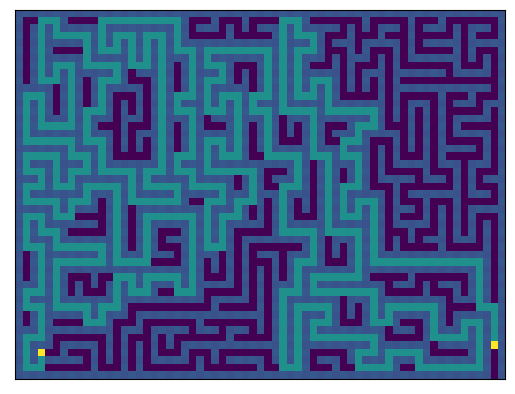

In [23]:
rows, cols = ind2sub(np.asarray(location_list[1:-1]))
kkk = maze_array.copy()
row_end, col_end = ind2sub(np.asarray(location_list[0]))
kkk[rows, cols] = 2
kkk[row_end, col_end] = 4
plt.imshow(kkk)
plt.xticks([])
plt.yticks([])
# plt.savefig('wgc3.png', dpi=300)

In [24]:
np.savetxt('tab_Q.txt', tab_Q)

## test the model

In [26]:
tab_Q = np.loadtxt('tab_Q.txt')
start = np.where(maze_array == np.max(maze_array))
walker = MazeWalker(tab_Q, start)

### randomly initialize and test the model

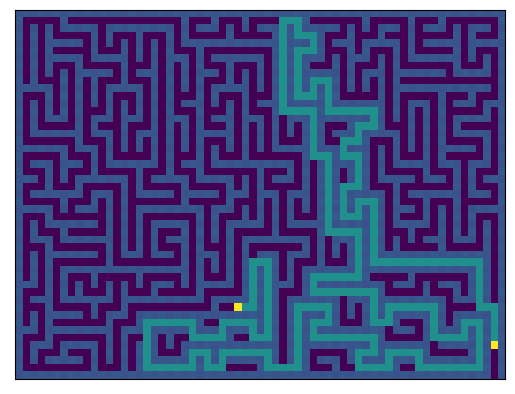

In [30]:
location_list, _ = walker.one_episode(train=False, end=None)
rows, cols = ind2sub(np.asarray(location_list[1:-1]))
kkk = maze_array.copy()
row_end, col_end = ind2sub(np.asarray(location_list[0]))
kkk[rows, cols] = 2
kkk[row_end, col_end] = 4
plt.imshow(kkk)
plt.xticks([])
plt.yticks([])
plt.show()

### test the model with user-specified end points

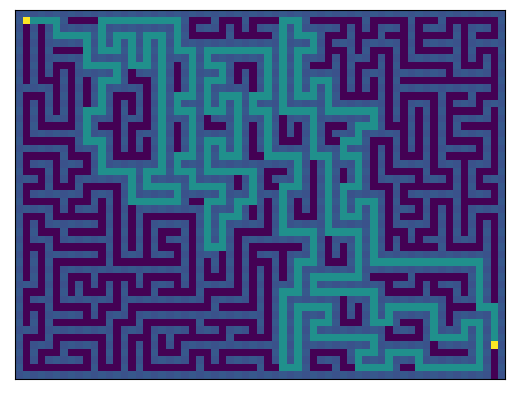

In [31]:
end = sub2ind(1,1)
location_list, _ = walker.one_episode(train=False, end=end)
rows, cols = ind2sub(np.asarray(location_list[1:-1]))
kkk = maze_array.copy()
row_end, col_end = ind2sub(np.asarray(location_list[0]))
kkk[rows, cols] = 2
kkk[row_end, col_end] = 4
plt.imshow(kkk)
plt.xticks([])
plt.yticks([])
plt.show()